# Maverik Time Series Forecasting Analysis- Modeling

<a class="anchor" id="TableofContents"></a>
## Table of Contents
* [1. Introduction - Business Statement](#1.Introduction-BusinessStatement)  
* [2. Exploratory Data Analysis](#2.ExploratoryDataAnalysis)    
* [3. Modeling process](#3.Modelingprocess)
    * [I. XGBoost Model](#I.XGBoostModel)
      * [A.Target Variable = Food](#A.TargetVariable=Food)
      * [B.Target Variable = Inside Sales](#B.TargetVariable=InsideSales)
* [4. Model Performance and Summary](#4.ModelPerformanceandSummary)

<a class="anchor" id="1.Introduction-BusinessStatement"></a>
# 1. Introduction - Business Statement

Maverik is currently facing a significant challenge in preparing comprehensive ROI documents for their new store openings. This challenge stems from the difficulty of accurately predicting first-year sales, which in turn hinders the company's strategic financial planning and decision-making processes, ultimately affecting their sustainable growth. To address this issue, the primary analytical goal is to develop a predictive model capable of providing precise daily forecasts for merchandise sales, food sales, unleaded fuel sales, and diesel fuel sales for new Maverik stores during their first year of operation.

The Modeling is dedicated to achieving this objective. Its purpose is to build a model that can forecast merchandise sales, food sales, unleaded fuel sales, and diesel fuel sales for the next 365 days using historical data as a basis. The notebook's focus is on evaluating various time series forecasting models to determine the most suitable option that aligns with Maverik's specific needs. Since there are four target variables involved, this constitutes a multivariate time series analysis. The two models tested here is XGBoost for 2 of the 4 variables.


<a class="anchor" id="2.ExploratoryDataAnalysis"></a>
# 2. Exploratory Data Analysis

In this section, we provide an overview of the Exploratory Data Analysis carried out as an integral part of the project. Following that, we delve into the Modeling phase, where we assess different models to identify the most suitable one for our future predictions.

This section also encompasses strategies for data preparation, which involves managing variable transformations, conducting feature engineering, and addressing missing values in the dataset.

<a class="anchor" id="2.1.ImportingPackages"></a>
## 2.1. Importing Packages

In [440]:
#pip install xgboost

In [471]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from pandas.plotting import table
import plotly.express as px
import matplotlib.ticker as mtick

In [472]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [473]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2.2. Reading Data

In [474]:
q_data= pd.read_csv("qualitative_data_msba.csv")
t_data=pd.read_csv("time_series_data_msba.csv")

## 2.3. Summarizing & Understading the Data

In [475]:
q_data.head()

,Unnamed: 0,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,...,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
0,1,2021,5046,2,2,38,Yes,Yes,Yes,No,...,6,Stack,HF/RV,No,Yes,2,2,6,2,21560
1,2,2021,5046,2,2,39,No,Yes,Yes,Yes,...,4,Combo,HF/RV,No,Yes,5,5,10,4,21980
2,3,2021,5046,2,2,35,Yes,Yes,Yes,Yes,...,5,In-Line,None,No,Yes,3,2,4,1,22015
3,4,2021,5046,2,2,36,No,Yes,Yes,Yes,...,4,Combo,HF/RV,No,Yes,3,3,6,2,22085
4,5,2021,5046,2,2,25,Yes,Yes,Yes,No,...,0,NaN,NaN,No,Yes,0,0,0,0,22120


In [476]:
t_data.head()

,Unnamed: 0,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba
0,1,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535
1,2,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535
2,3,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535
3,4,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535
4,5,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535


<a class="anchor" id="2.1.ImportingPackages"></a>
### 2.3.1 Removing 1st column from both the dataframes named 'Unnamed: 0'

In [477]:
q_data= q_data.drop("Unnamed: 0", axis=1)
t_data= t_data.drop("Unnamed: 0", axis=1)

In [478]:
q_data.head()

,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,cinnabon,...,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
0,2021,5046,2,2,38,Yes,Yes,Yes,No,No,...,6,Stack,HF/RV,No,Yes,2,2,6,2,21560
1,2021,5046,2,2,39,No,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,5,5,10,4,21980
2,2021,5046,2,2,35,Yes,Yes,Yes,Yes,No,...,5,In-Line,None,No,Yes,3,2,4,1,22015
3,2021,5046,2,2,36,No,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,3,3,6,2,22085
4,2021,5046,2,2,25,Yes,Yes,Yes,No,No,...,0,NaN,NaN,No,Yes,0,0,0,0,22120


In [479]:
t_data.head()

,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba
0,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535
1,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535
2,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535
3,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535
4,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535


<a class="anchor" id="2.1.ImportingPackages"></a>
### 2.3.2 Identified Zero Variance Variables
The following columns exhibit consistent values throughout and do not demonstrate significant correlation with the target variables. Therefore, they can be considered as zero variance variables and may be removed from the dataset:
 1. front_door_count
 2. godfather_s_pizza
 3. diesel
 4. car_wash
 5. ev_charging
 6. non_24_hour
 7. self_check_out

In [480]:
q_data.drop(['front_door_count','godfather_s_pizza','car_wash','ev_charging','non_24_hour','self_check_out','diesel'], axis=1,inplace=True)

<a class="anchor" id="2.1.ImportingPackages"></a>
### 2.3.3 Checking the shape of q_data after columns drop

In [481]:
q_data.shape

(37, 47)

<a class="anchor" id="2.1.ImportingPackages"></a>
### 2.3.4 Finding NA and Categorical Values  in Qualitative Dataframe (q_data)

In [482]:
na_values = q_data.isna().sum()
na_values[na_values > 0]

rv_lanes_layout                14
rv_lanes_stack_type            14
hi_flow_lanes_layout           15
hi_flow_lanes_stack_type       15
hi_flow_rv_lanes_layout        14
hi_flow_rv_lanes_stack_type    14
dtype: int64

As per the above result, 6 columns of qualitative dataframe has N/A value. It means that Maverik does not provide these features in few of it stores.

In [483]:
cat_col= q_data.select_dtypes(include="object").columns.tolist()
cat_col

['lottery',
 'freal',
 'bonfire_grill',
 'pizza',
 'cinnabon',
 'ethanol_free',
 'hi_flow_lanes',
 'rv_lanes',
 'hi_flow_rv_lanes',
 'def',
 'cat_scales',
 'rv_dumps',
 'propane',
 'traditional_forecourt_layout',
 'traditional_forecourt_stack_type',
 'rv_lanes_layout',
 'rv_lanes_stack_type',
 'hi_flow_lanes_layout',
 'hi_flow_lanes_stack_type',
 'hi_flow_rv_lanes_layout',
 'hi_flow_rv_lanes_stack_type']

### 2.3.5 Replacing NA values with None

In [484]:
columns_with_na = q_data.columns[q_data.isna().any()].tolist()

for column in columns_with_na:
    mode_value = q_data[column].mode()[0]
    q_data[column].fillna("None", inplace=True)

### 2.3.6 Factorizing the Categorical columns

In [485]:
for column in cat_col:
    q_data[column] = pd.factorize(q_data[column])[0]

In [486]:
import pandas as pd

# Define bins and labels
bins = [20, 30, 40, 50]
labels = [1, 2, 3]

# Bin the values in the 'parking_spaces' column
q_data['parking_spaces'] = pd.cut(q_data['parking_spaces'], bins=bins, labels=labels, include_lowest=True).astype(int)

In [487]:
q_data.head()

,open_year,square_feet,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,cinnabon,ethanol_free,...,hi_flow_lanes_stack_type,hi_flow_lanes_fueling_positions_2,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
0,2021,5046,2,2,0,0,0,0,0,0,...,0,4,6,0,0,2,2,6,2,21560
1,2021,5046,2,2,1,0,0,1,0,1,...,0,9,4,1,0,5,5,10,4,21980
2,2021,5046,2,2,0,0,0,1,0,0,...,1,0,5,2,1,3,2,4,1,22015
3,2021,5046,2,2,1,0,0,1,0,0,...,0,5,4,1,0,3,3,6,2,22085
4,2021,5046,2,1,0,0,0,0,0,1,...,1,0,0,3,1,0,0,0,0,22120


### 2.3.7 Finding NA and Categorical Values in Time Series Dataframe (t_data)

In [488]:
na_values = t_data.isna().sum()
na_values[na_values > 0]

Series([], dtype: int64)

There are no columns in time series data that has N/A value

### 2.3.8 Extracting Year, Month and Date from Calendar_day_date

In [489]:
t_data['calendar.calendar_day_date'] = pd.to_datetime(t_data['calendar.calendar_day_date'])

t_data['calendar_year'] = t_data['calendar.calendar_day_date'].dt.year
t_data['calendar_month'] = t_data['calendar.calendar_day_date'].dt.month
t_data['calendar_day'] = t_data['calendar.calendar_day_date'].dt.day

In [490]:
t_data.head()

,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba,calendar_year,calendar_month,calendar_day
0,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535,2022,6,17
1,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535,2022,6,22
2,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535,2022,6,23
3,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535,2022,6,26
4,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535,2022,6,27


## 2.4. Analysis On Qualitative and Time Series Data

Sales of all target variables based on Calendar Week

In [501]:
t_data['calendar.fiscal_week_id_for_year'].min(), t_data['calendar.fiscal_week_id_for_year'].max()

(1, 52)

In [502]:
df_time_aggregate = t_data.groupby('calendar.fiscal_week_id_for_year')['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel', 'unleaded'].sum().reset_index()

In [503]:
temp = t_data.groupby('calendar.fiscal_week_id_for_year')['daily_yoy_ndt.total_inside_sales'].size()
temp[temp > 1].sort_values(ascending=False)

calendar.fiscal_week_id_for_year
20    273
38    270
13    270
33    270
28    270
24    270
21    270
49    270
45    270
19    269
11    268
46    268
39    268
32    268
31    268
30    268
29    268
4     268
2     268
26    268
25    268
5     268
42    268
50    268
18    268
15    268
9     268
41    266
48    266
37    266
43    266
44    266
51    266
40    266
47    266
1     266
27    266
36    266
35    266
34    266
23    266
22    266
17    266
16    266
14    266
12    266
10    266
8     266
7     266
6     266
3     266
52    266
Name: daily_yoy_ndt.total_inside_sales, dtype: int64

#### Indexing with Time Series Data

In [504]:
df_time_aggregate = df_time_aggregate.set_index('calendar.fiscal_week_id_for_year')
df_time_aggregate.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52],
           dtype='int64', name='calendar.fiscal_week_id_for_year')

## 2.5. Merging both dataframes

In [506]:
df_merged=pd.merge(t_data,q_data, on='site_id_msba', how='left')

In [507]:
df_merged.shape

(13908, 59)

In [508]:
df_merged.head()

,capital_projects.soft_opening_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba,...,hi_flow_lanes_layout,hi_flow_lanes_stack_type,hi_flow_lanes_fueling_positions_2,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count
0,2022-06-14,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,2.0
1,2022-06-14,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,2.0
2,2022-06-14,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,2.0
3,2022-06-14,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,2.0
4,2022-06-14,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,2.0


#### Correlation Heatmaps

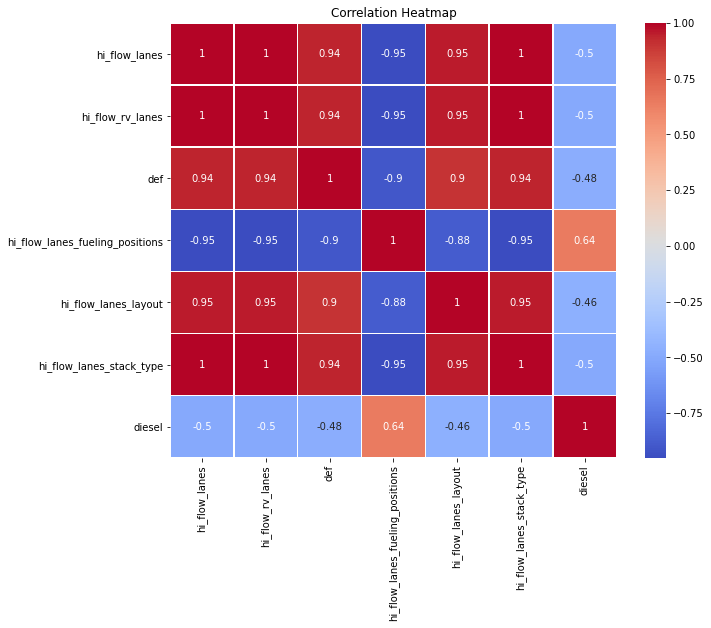

In [564]:
numerical_columns = ['hi_flow_lanes', 'hi_flow_rv_lanes', 'def',
                     'hi_flow_lanes_fueling_positions', 'hi_flow_lanes_layout',
                     'hi_flow_lanes_stack_type', 'diesel']

subset_df = df_merged[numerical_columns]

correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


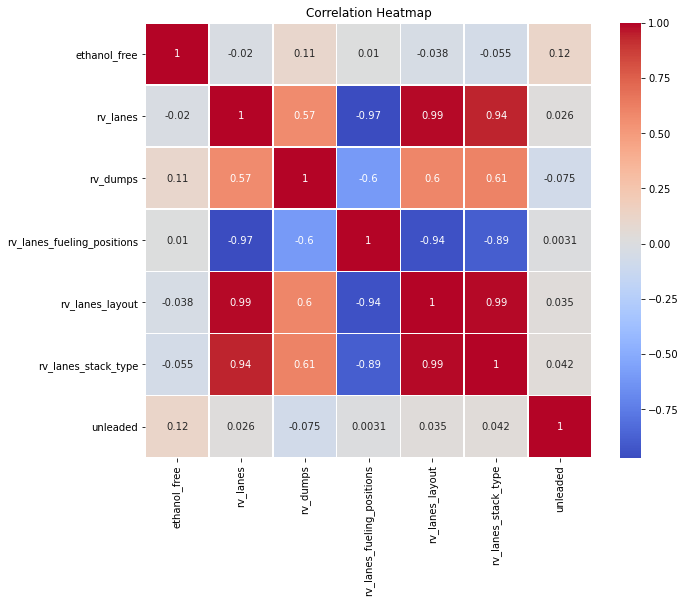

In [565]:
numerical_columns =  [ 'ethanol_free', 'rv_lanes', 'rv_dumps',
                        'rv_lanes_fueling_positions', 'rv_lanes_layout',
                        'rv_lanes_stack_type', 'unleaded']

subset_df = df_merged[numerical_columns]


correlation_matrix = subset_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


<a class="anchor" id="2.1.ImportingPackages"></a>
## 2.6. Feature Engineering

In [511]:
df_merged['calendar.calendar_day_date'] = t_data.index

In [512]:
df_merged.set_index('calendar.calendar_day_date', inplace=True)

### 2.6.1 One Hot Encoding

In [513]:
# Identifying categorical columns
categorical_columns = df_merged.select_dtypes(include=['object']).columns

# Applying one-hot encoding to categorical columns
encoded_df = pd.get_dummies(df_merged, columns=categorical_columns)

In [514]:
encoded_df.head()

,calendar.fiscal_week_id_for_year,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba,calendar_year,calendar_month,calendar_day,open_year,...,calendar_information.holiday_New Year's Eve,calendar_information.holiday_Palm Sunday,calendar_information.holiday_President's Day,calendar_information.holiday_Saint Patrick's Day,calendar_information.holiday_Saint Valentine's Day,calendar_information.holiday_Thanksgiving Day,calendar_information.holiday_Veteran's Day,calendar_information.holiday_Washington's Birthday,calendar_information.type_of_day_WEEKDAY,calendar_information.type_of_day_WEEKEND
calendar.calendar_day_date,,,,,,,,,,,,,,,,,,,,,
2022-06-17,25,2168.2920,861.6930,722.7745,1425.1020,24535,2022,6,17,2022.0,...,0,0,0,0,0,0,0,0,1,0
2022-06-22,25,2051.5635,808.0275,730.4850,1436.2740,24535,2022,6,22,2022.0,...,0,0,0,0,0,0,0,0,1,0
2022-06-23,25,2257.5000,966.4410,895.7970,1594.3725,24535,2022,6,23,2022.0,...,0,0,0,0,0,0,0,0,1,0
2022-06-26,26,1520.5925,542.3250,584.2900,1124.9280,24535,2022,6,26,2022.0,...,0,0,0,0,0,0,0,0,0,1
2022-06-27,26,1897.6930,771.4525,852.2605,1640.2540,24535,2022,6,27,2022.0,...,0,0,0,0,0,0,0,0,1,0


'encoded_df' now contains the original columns along with one-hot encoded categorical columns

<a class="anchor" id="3.Modelingprocess"></a>
# 3. Modeling process

<a class="anchor" id="I.XGBoostModel"></a>
## I. XGBoost Model

<a class="anchor" id="A.TargetVariable=Food"></a>
### A.Target Variable = Food

#### Plotting the graph for sale of food over the years

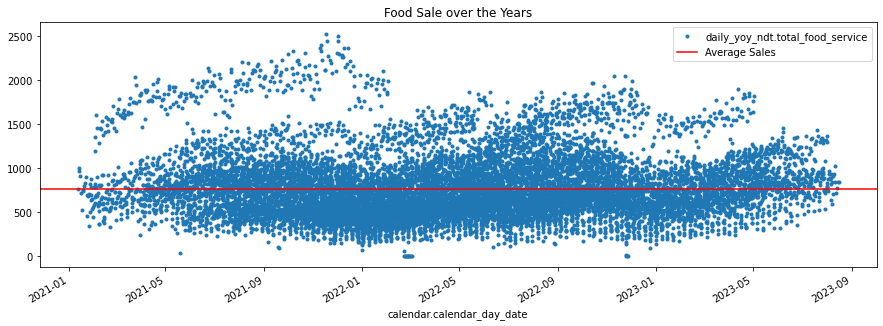

In [515]:
average_sales = encoded_df['daily_yoy_ndt.total_food_service'].mean()
encoded_df['daily_yoy_ndt.total_food_service'].plot(style=".", figsize=(15,5), title="Food Sale over the Years")
plt.axhline(y=average_sales, color='r', linestyle='-', label='Average Sales')
plt.legend()
plt.show()

#### Train Test Split

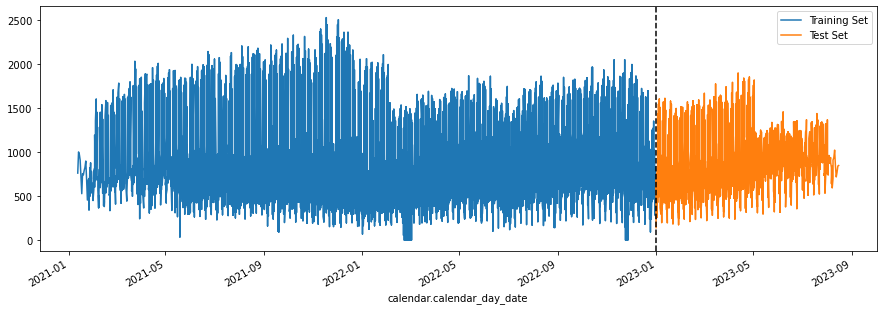

In [516]:
#splitting train as date less than 1st jan 2023 and test as later

train= encoded_df['daily_yoy_ndt.total_food_service'].loc[encoded_df.index< '2023-01-01']
test= encoded_df['daily_yoy_ndt.total_food_service'].loc[encoded_df.index>= '2023-01-01']
fig, ax= plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='training set')
test.plot(ax=ax, label='Test set')
ax.axvline('2023-01-01',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

#### Splitting data into training and testing sets

In [517]:
# Features (X) and Target (y)
X = encoded_df.drop(columns=['daily_yoy_ndt.total_food_service'])
y = encoded_df['daily_yoy_ndt.total_food_service']

train_end_date = '2023-01-01'
X_train = X[X.index < train_end_date]
X_test = X[X.index >= train_end_date]
y_train = y[y.index < train_end_date]
y_test = y[y.index >= train_end_date]

#### We now have X_train, X_test, y_train, and y_test ready for modeling

In [518]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:822.39842	validation_1-rmse:839.64100
[100]	validation_0-rmse:323.95632	validation_1-rmse:350.71905
[200]	validation_0-rmse:151.92026	validation_1-rmse:162.09565
[300]	validation_0-rmse:98.47457	validation_1-rmse:102.89766
[400]	validation_0-rmse:82.86013	validation_1-rmse:85.75687
[500]	validation_0-rmse:76.87139	validation_1-rmse:83.80122
[517]	validation_0-rmse:76.22090	validation_1-rmse:83.83548


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Identifying Top 10 features impacting the Food Sale

<AxesSubplot:title={'center':'Top 10 Feature Importance'}>

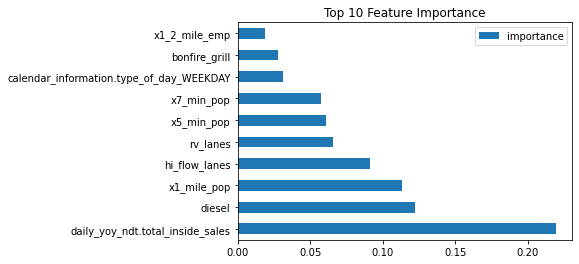

In [519]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
top_10_features = fi.sort_values(by='importance', ascending=False).head(10)
top_10_features.plot(kind='barh', title='Top 10 Feature Importance')

#### Plotting the graph to depict Train and Test Split

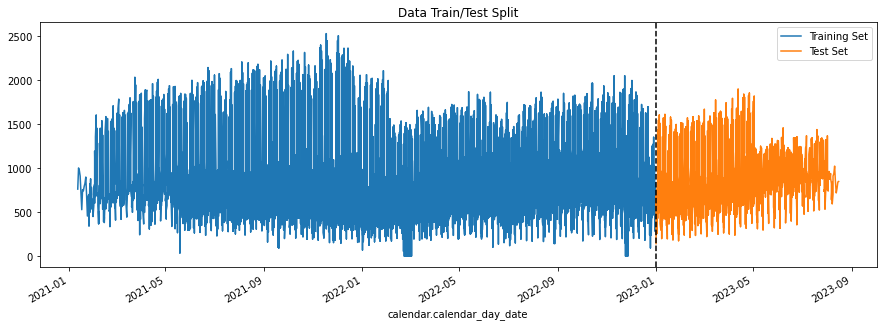

In [520]:
train = encoded_df[['daily_yoy_ndt.total_food_service','x1_2_mile_pop','x7_min_pop','x1_mile_pop','womens_sink_count','hi_flow_lanes','square_feet','x1_2_mile_emp','x5_min_pop']].loc[encoded_df.index < '2023-01-01']
test = encoded_df[['daily_yoy_ndt.total_food_service','x1_2_mile_pop','x7_min_pop','x1_mile_pop','womens_sink_count','hi_flow_lanes','square_feet','x1_2_mile_emp','x5_min_pop']].loc[encoded_df.index >= '2023-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['daily_yoy_ndt.total_food_service'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['daily_yoy_ndt.total_food_service'].plot(ax=ax, label='Test Set')
ax.axvline('2023-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### Time series cross validation

In [521]:
tss = TimeSeriesSplit(n_splits=5)
df = encoded_df[['daily_yoy_ndt.total_food_service','x1_2_mile_pop','x7_min_pop','x1_mile_pop','womens_sink_count','hi_flow_lanes','square_feet','x1_2_mile_emp','x5_min_pop']].sort_index()

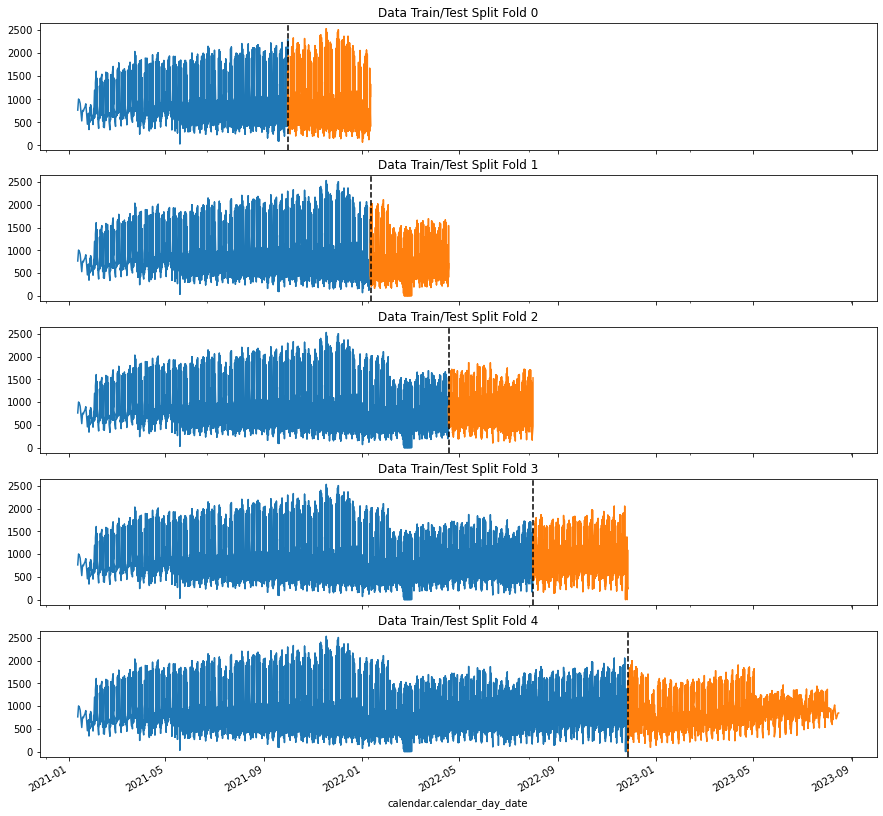

In [522]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['daily_yoy_ndt.total_food_service'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['daily_yoy_ndt.total_food_service'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### Creating time series features based on time series index

In [523]:
def create_features(df):
   
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [524]:
df.head()

,daily_yoy_ndt.total_food_service,x1_2_mile_pop,x7_min_pop,x1_mile_pop,womens_sink_count,hi_flow_lanes,square_feet,x1_2_mile_emp,x5_min_pop,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
calendar.calendar_day_date,,,,,,,,,,,,,,,,
2021-01-12,762.8530,556.0,13895.0,4046.0,2.0,0.0,5046.0,642.0,4776.0,1,1,1,2021,12,12,2
2021-01-13,1003.7930,556.0,13895.0,4046.0,2.0,0.0,5046.0,642.0,4776.0,2,1,1,2021,13,13,2
2021-01-14,974.2250,556.0,13895.0,4046.0,2.0,0.0,5046.0,642.0,4776.0,3,1,1,2021,14,14,2
2021-01-15,911.0115,556.0,13895.0,4046.0,2.0,0.0,5046.0,642.0,4776.0,4,1,1,2021,15,15,2
2021-01-16,715.7535,556.0,13895.0,4046.0,2.0,0.0,5046.0,642.0,4776.0,5,1,1,2021,16,16,2


#### Defining Lags

In [525]:
def add_lags(df):
  target_map= df['daily_yoy_ndt.total_food_service'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  return df

In [526]:
df = add_lags(df)

In [527]:
df.tail()

,daily_yoy_ndt.total_food_service,x1_2_mile_pop,x7_min_pop,x1_mile_pop,womens_sink_count,hi_flow_lanes,square_feet,x1_2_mile_emp,x5_min_pop,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1
calendar.calendar_day_date,,,,,,,,,,,,,,,,,
2023-08-12,843.5980,1003.0,26142.0,3629.0,2.0,1.0,2933.0,656.0,15721.0,5,3,8,2023,224,12,32,427.9555
2023-08-13,719.3655,1003.0,26142.0,3629.0,2.0,1.0,2933.0,656.0,15721.0,6,3,8,2023,225,13,32,719.5720
2023-08-14,772.2015,1003.0,26142.0,3629.0,2.0,1.0,2933.0,656.0,15721.0,0,3,8,2023,226,14,33,1185.7580
2023-08-15,843.6260,1003.0,26142.0,3629.0,2.0,1.0,2933.0,656.0,15721.0,1,3,8,2023,227,15,33,1023.3580
2023-08-16,849.2155,1003.0,26142.0,3629.0,2.0,1.0,2933.0,656.0,15721.0,2,3,8,2023,228,16,33,1043.0910


#### Fitting the Model to calculate Evaluation Metrics

In [528]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    TARGET = 'daily_yoy_ndt.total_food_service'

    X_train = train
    y_train = train[TARGET]

    X_test = test
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:900.37986	validation_1-rmse:769.04199
[100]	validation_0-rmse:333.74327	validation_1-rmse:292.01687
[200]	validation_0-rmse:124.27877	validation_1-rmse:114.91425
[300]	validation_0-rmse:46.89231	validation_1-rmse:49.86633
[400]	validation_0-rmse:18.72936	validation_1-rmse:27.32857
[500]	validation_0-rmse:9.38798	validation_1-rmse:19.05138
[600]	validation_0-rmse:6.74452	validation_1-rmse:16.45057
[700]	validation_0-rmse:5.94223	validation_1-rmse:15.63134
[800]	validation_0-rmse:5.30668	validation_1-rmse:15.44082
[878]	validation_0-rmse:4.94239	validation_1-rmse:15.43741
[0]	validation_0-rmse:837.20350	validation_1-rmse:725.43047
[100]	validation_0-rmse:309.97102	validation_1-rmse:267.77492
[200]	validation_0-rmse:115.34908	validation_1-rmse:99.82656
[300]	validation_0-rmse:43.61596	validation_1-rmse:39.04170
[400]	validation_0-rmse:17.78054	validation_1-rmse:18.11731
[500]	validation_0-rmse:9.43339	validation_1-rmse:12.21894
[600]	validation_0-rmse:7.18926	validat

#### Calculation of evaluation metrics

In [529]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')

Mean Absolute Error (MAE): 2.51
Mean Squared Error (MSE): 34.41
R-squared (R2) Score: 1.00


In [530]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 9.2483
Fold scores:[15.417562994216306, 10.172874194603201, 7.403989385508004, 7.380996807829316, 5.866085208822315]


#### Retraining all data

In [531]:
future = pd.date_range('2023-08-17','2024-12-31', freq='D')
future_df = pd.DataFrame(index=future)
df['isFuture'] = False

TARGET = 'daily_yoy_ndt.total_food_service'

# Define features (excluding the target and 'isFuture' column)
FEATURES = ['x1_2_mile_pop','x7_min_pop','x1_mile_pop','womens_sink_count','hi_flow_lanes','square_feet','x1_2_mile_emp','x5_min_pop',
            'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear', 'lag1','isFuture']

# Split the data into features (X) and target (y)
X = df[FEATURES]
y = df[TARGET]

# Create the XGBoost model
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

# Fit the model
reg.fit(X, y, eval_set=[(X, y)], verbose=100)

[0]	validation_0-rmse:824.88453
[100]	validation_0-rmse:354.95450
[200]	validation_0-rmse:214.38252
[300]	validation_0-rmse:175.46706
[400]	validation_0-rmse:160.48654
[499]	validation_0-rmse:151.25179


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Creating Future Dataframe

In [532]:
future = pd.date_range('2023-08-17','2024-12-31', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [533]:
future_w_features = df_and_future.query('isFuture').copy()

In [534]:
future_w_features.head()

,daily_yoy_ndt.total_food_service,x1_2_mile_pop,x7_min_pop,x1_mile_pop,womens_sink_count,hi_flow_lanes,square_feet,x1_2_mile_emp,x5_min_pop,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,isFuture
2023-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,8,2023,229,17,33,1078.1330,True
2023-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,8,2023,230,18,33,697.9175,True
2023-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,8,2023,231,19,33,531.1845,True
2023-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,3,8,2023,232,20,33,366.8105,True
2023-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,8,2023,233,21,34,1395.0475,True


In [535]:
future_w_features = future_w_features.drop('daily_yoy_ndt.total_food_service', axis=1)

In [536]:
future_w_features['pred'] = reg.predict(future_w_features)

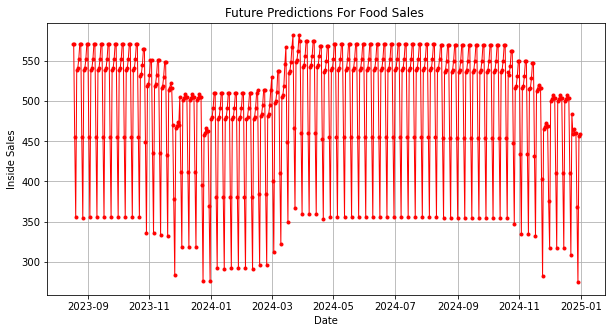

In [537]:
future_w_features.index = pd.to_datetime(future_w_features.index)  # Make sure index is datetime
plt.figure(figsize=(10, 5))
plt.plot(future_w_features.index, future_w_features['pred'], color='r', marker='o', linestyle='-', linewidth=1, markersize=3)
plt.title('Future Predictions For Food Sales ')
plt.xlabel('Date')
plt.ylabel('Inside Sales')
plt.grid(True)
plt.show()

#### Combining Future Prediction with the Historical Data

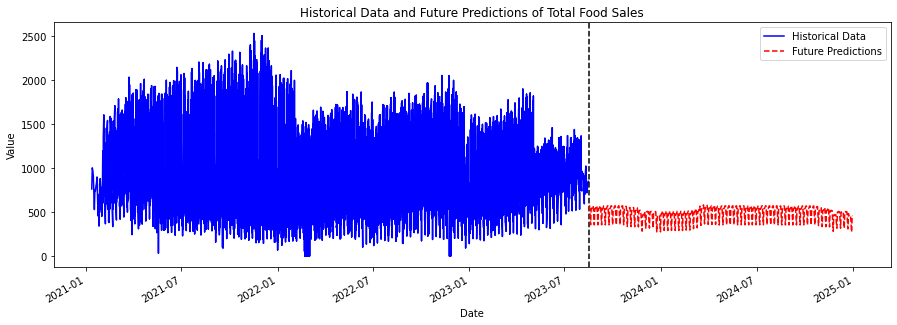

In [538]:
# Plotting historical data
plt.figure(figsize=(15, 5))

# Plot the entire historical data
encoded_df['daily_yoy_ndt.total_food_service'].plot(label='Historical Data', color='b')
plt.axvline('2023-08-17', color='black', ls='--')
# Plot future predictions
plt.plot(future_w_features.index, future_w_features['pred'], label='Future Predictions', color='red', linestyle='dashed')

# Set title and labels
plt.title('Historical Data and Future Predictions of Total Food Sales')
plt.xlabel('Date')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show plot
plt.show()

#### Displaying the data for future predictions

In [539]:
start_date = '2023-08-17'
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=502)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')


# Create a DataFrame for the forecasted sales
forecasted_sales_df = pd.DataFrame({'Date': date_range, 'Sales': future_w_features['pred']})

# Display the DataFrame
print(forecasted_sales_df)

                 Date       Sales
2023-08-17 2023-08-17  571.028748
2023-08-18 2023-08-18  571.028748
2023-08-19 2023-08-19  455.485229
2023-08-20 2023-08-20  355.408234
2023-08-21 2023-08-21  538.371643
...               ...         ...
2024-12-27 2024-12-27  460.862305
2024-12-28 2024-12-28  368.136261
2024-12-29 2024-12-29  274.111053
2024-12-30 2024-12-30  457.074554
2024-12-31 2024-12-31  459.541840

[503 rows x 2 columns]


<a class="anchor" id="B.TargetVariable=InsideSales"></a>
### B.Target Variable = Inside Sales

#### Plotting the graph for sale of food over the years

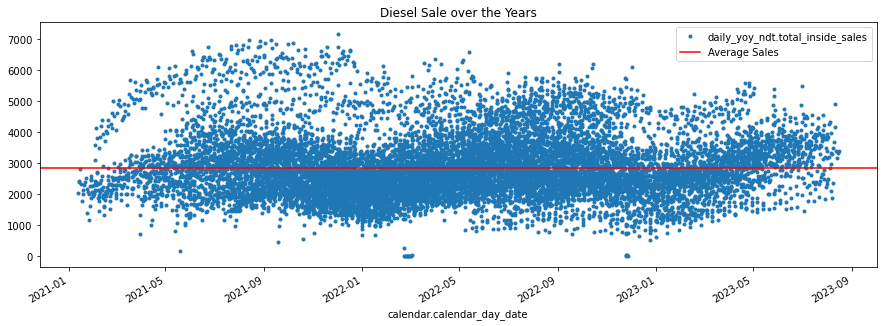

In [540]:
average_sales = encoded_df['daily_yoy_ndt.total_inside_sales'].mean()
encoded_df['daily_yoy_ndt.total_inside_sales'].plot(style=".", figsize=(15,5), title="Diesel Sale over the Years")
plt.axhline(y=average_sales, color='r', linestyle='-', label='Average Sales')
plt.legend()
plt.show()


#### Train Test Split

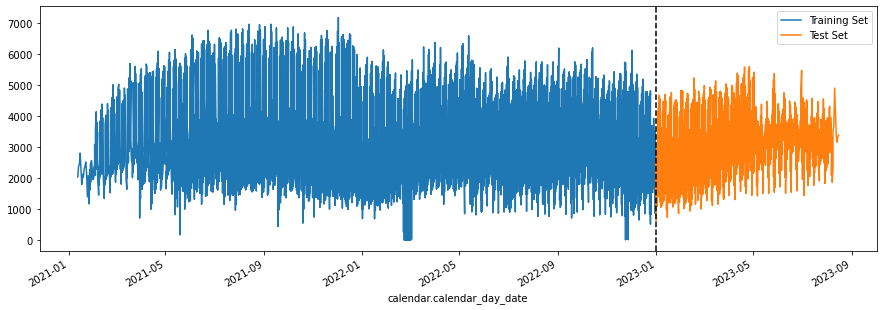

In [541]:
train= encoded_df['daily_yoy_ndt.total_inside_sales'].loc[encoded_df.index< '2023-01-01']
test= encoded_df['daily_yoy_ndt.total_inside_sales'].loc[encoded_df.index>= '2023-01-01']
fig, ax= plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='training set')
test.plot(ax=ax, label='Test set')
ax.axvline('2023-01-01',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

#### Splitting data into training and testing sets

In [542]:
# Features (X) and Target (y)
X = encoded_df.drop(columns=['daily_yoy_ndt.total_inside_sales'])
y = encoded_df['daily_yoy_ndt.total_inside_sales']

# Split data into training and testing sets
train_end_date = '2023-01-01'
X_train = X[X.index < train_end_date]
X_test = X[X.index >= train_end_date]
y_train = y[y.index < train_end_date]
y_test = y[y.index >= train_end_date]

#### We now have X_train, X_test, y_train, and y_test ready for modeling

In [543]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2983.72798	validation_1-rmse:2964.42797
[100]	validation_0-rmse:1168.03834	validation_1-rmse:1190.59259
[200]	validation_0-rmse:557.10795	validation_1-rmse:616.34768
[300]	validation_0-rmse:377.06178	validation_1-rmse:447.02968
[400]	validation_0-rmse:318.58197	validation_1-rmse:392.17497
[500]	validation_0-rmse:287.58209	validation_1-rmse:375.73879
[583]	validation_0-rmse:268.54085	validation_1-rmse:375.21787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Identifying Top 10 features impacting the Inside Sale

<AxesSubplot:title={'center':'Top 10 Feature Importance'}>

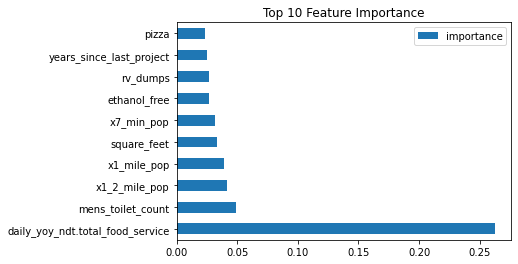

In [544]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
top_10_features = fi.sort_values(by='importance', ascending=False).head(10)
top_10_features.plot(kind='barh', title='Top 10 Feature Importance')

#### Plotting the graph to depict Train and Test Split

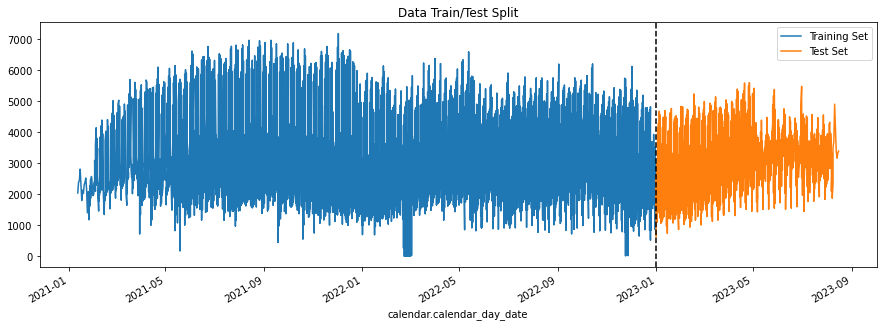

In [545]:
train = encoded_df[['daily_yoy_ndt.total_inside_sales','x5_min_pop','x1_2_mile_emp','square_feet','hi_flow_lanes','womens_sink_count','x1_mile_pop','x7_min_pop','x1_2_mile_pop']].loc[encoded_df.index < '2023-01-01']
test = encoded_df[['daily_yoy_ndt.total_inside_sales','x5_min_pop','x1_2_mile_emp','square_feet','hi_flow_lanes','womens_sink_count','x1_mile_pop','x7_min_pop','x1_2_mile_pop']].loc[encoded_df.index >= '2023-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['daily_yoy_ndt.total_inside_sales'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['daily_yoy_ndt.total_inside_sales'].plot(ax=ax, label='Test Set')
ax.axvline('2023-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### Time series cross validation

In [546]:
tss = TimeSeriesSplit(n_splits=5)
df = encoded_df[['daily_yoy_ndt.total_inside_sales','x5_min_pop','x1_2_mile_emp','square_feet','hi_flow_lanes','womens_sink_count','x1_mile_pop','x7_min_pop','x1_2_mile_pop']].sort_index()

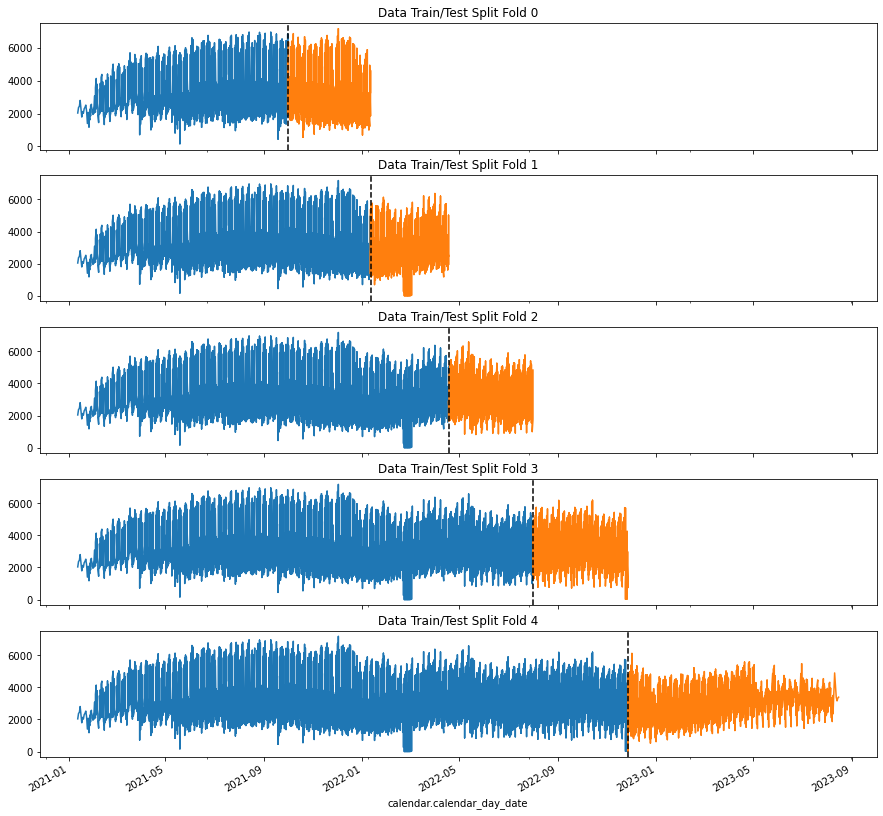

In [547]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['daily_yoy_ndt.total_inside_sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['daily_yoy_ndt.total_inside_sales'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### Creating time series features based on time series index

In [548]:
def create_features(df):
  
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

#### Defining Lags

In [549]:
def add_lags(df):
  target_map= df['daily_yoy_ndt.total_inside_sales'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  return df

In [550]:
df = add_lags(df)

In [551]:
df.tail()

,daily_yoy_ndt.total_inside_sales,x5_min_pop,x1_2_mile_emp,square_feet,hi_flow_lanes,womens_sink_count,x1_mile_pop,x7_min_pop,x1_2_mile_pop,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1
calendar.calendar_day_date,,,,,,,,,,,,,,,,,
2023-08-12,4160.1840,15721.0,656.0,2933.0,1.0,2.0,3629.0,26142.0,1003.0,5,3,8,2023,224,12,32,3775.6565
2023-08-13,3378.9595,15721.0,656.0,2933.0,1.0,2.0,3629.0,26142.0,1003.0,6,3,8,2023,225,13,32,2600.2270
2023-08-14,3156.0760,15721.0,656.0,2933.0,1.0,2.0,3629.0,26142.0,1003.0,0,3,8,2023,226,14,33,3868.9805
2023-08-15,3331.7060,15721.0,656.0,2933.0,1.0,2.0,3629.0,26142.0,1003.0,1,3,8,2023,227,15,33,3613.2180
2023-08-16,3389.2145,15721.0,656.0,2933.0,1.0,2.0,3629.0,26142.0,1003.0,2,3,8,2023,228,16,33,4138.0465


#### Fitting the Model to calculate the Evaluation Metrics

In [552]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    TARGET = 'daily_yoy_ndt.total_inside_sales'

    X_train = train
    y_train = train[TARGET]

    X_test = test
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:3212.66650	validation_1-rmse:2766.10785
[100]	validation_0-rmse:1187.70785	validation_1-rmse:1018.71994
[200]	validation_0-rmse:440.61188	validation_1-rmse:376.68833
[300]	validation_0-rmse:165.06766	validation_1-rmse:141.22462
[400]	validation_0-rmse:64.89871	validation_1-rmse:57.50594
[500]	validation_0-rmse:31.69412	validation_1-rmse:31.91429
[600]	validation_0-rmse:22.72672	validation_1-rmse:26.90735
[700]	validation_0-rmse:20.61346	validation_1-rmse:26.60712
[800]	validation_0-rmse:19.51697	validation_1-rmse:26.47496
[821]	validation_0-rmse:18.99840	validation_1-rmse:26.51733
[0]	validation_0-rmse:2997.70829	validation_1-rmse:2714.74294
[100]	validation_0-rmse:1105.74657	validation_1-rmse:999.59581
[200]	validation_0-rmse:409.25039	validation_1-rmse:373.72285
[300]	validation_0-rmse:152.90990	validation_1-rmse:150.63920
[400]	validation_0-rmse:59.87506	validation_1-rmse:79.87488
[500]	validation_0-rmse:29.11772	validation_1-rmse:63.31559
[600]	validation_0-rm

#### Calculation of evaluation metrics

In [553]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')

Mean Absolute Error (MAE): 6.68
Mean Squared Error (MSE): 423.45
R-squared (R2) Score: 1.00


In [554]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 34.1799
Fold scores:[26.32531560348755, 57.647557270326715, 36.444747538375125, 29.9040486216201, 20.577852455332305]


#### Retraining all data

In [555]:
future = pd.date_range('2023-08-17','2024-12-31', freq='D')
future_df = pd.DataFrame(index=future)
df['isFuture'] = False

TARGET = 'daily_yoy_ndt.total_inside_sales'

# Define features (excluding the target and 'isFuture' column)
FEATURES = ['x5_min_pop', 'x1_2_mile_emp', 'square_feet', 'hi_flow_lanes',
            'womens_sink_count', 'x1_mile_pop', 'x7_min_pop', 'x1_2_mile_pop',
            'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear', 'lag1', 'isFuture']

# Split the data into features (X) and target (y)
X = df[FEATURES]
y = df[TARGET]

# Create the XGBoost model
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

# Fit the model
reg.fit(X, y, eval_set=[(X, y)], verbose=100)


[0]	validation_0-rmse:2982.21578
[100]	validation_0-rmse:1283.71297
[200]	validation_0-rmse:772.01172
[300]	validation_0-rmse:629.83717
[400]	validation_0-rmse:573.02563
[499]	validation_0-rmse:535.61456


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Creating Future Dataframe

In [556]:
future = pd.date_range('2023-08-17','2024-12-31', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [557]:
future_w_features = df_and_future.query('isFuture').copy()

In [558]:
future_w_features.head()

,daily_yoy_ndt.total_inside_sales,x5_min_pop,x1_2_mile_emp,square_feet,hi_flow_lanes,womens_sink_count,x1_mile_pop,x7_min_pop,x1_2_mile_pop,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,isFuture
2023-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,8,2023,229,17,33,3871.1925,True
2023-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,8,2023,230,18,33,3635.4395,True
2023-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,8,2023,231,19,33,2902.2000,True
2023-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,3,8,2023,232,20,33,2724.3825,True
2023-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,8,2023,233,21,34,4579.2355,True


In [559]:
future_w_features = future_w_features.drop('daily_yoy_ndt.total_inside_sales', axis=1)

In [560]:
future_w_features['pred'] = reg.predict(future_w_features)

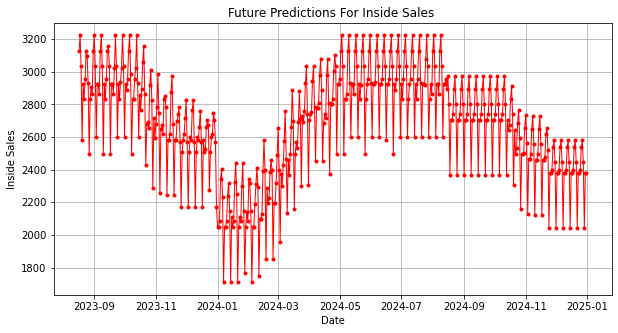

In [561]:
future_w_features.index = pd.to_datetime(future_w_features.index)  # Make sure index is datetime
plt.figure(figsize=(10, 5))
plt.plot(future_w_features.index, future_w_features['pred'], color='r', marker='o', linestyle='-', linewidth=1, markersize=3)
plt.title('Future Predictions For Inside Sales ')
plt.xlabel('Date')
plt.ylabel('Inside Sales')
plt.grid(True)
plt.show()

#### Combining Future Prediction with the Historical Data

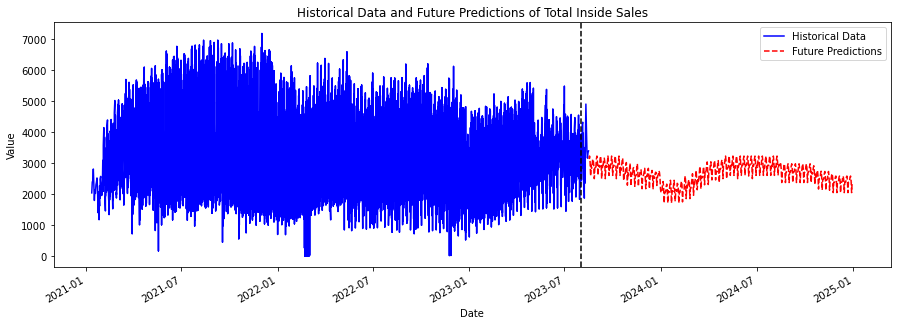

In [562]:
plt.figure(figsize=(15, 5))

# Plot the entire historical data
encoded_df['daily_yoy_ndt.total_inside_sales'].plot(label='Historical Data', color='b')
plt.axvline('2023-08-01', color='black', ls='--')
# Plot future predictions
plt.plot(future_w_features.index, future_w_features['pred'], label='Future Predictions', color='red', linestyle='dashed')

# Set title and labels
plt.title('Historical Data and Future Predictions of Total Inside Sales')
plt.xlabel('Date')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show plot
plt.show()

#### Displaying the data for future predictions

In [563]:
start_date = '2023-08-17'
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=502)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')


# Create a DataFrame for the forecasted sales
forecasted_sales_df = pd.DataFrame({'Date': date_range, 'Sales': future_w_features['pred']})

# Display the DataFrame
print(forecasted_sales_df)

                 Date        Sales
2023-08-17 2023-08-17  3126.451172
2023-08-18 2023-08-18  3223.762939
2023-08-19 2023-08-19  3034.069336
2023-08-20 2023-08-20  2579.458496
2023-08-21 2023-08-21  2923.774170
...               ...          ...
2024-12-27 2024-12-27  2579.044922
2024-12-28 2024-12-28  2444.546875
2024-12-29 2024-12-29  2044.809082
2024-12-30 2024-12-30  2381.798828
2024-12-31 2024-12-31  2381.798828

[503 rows x 2 columns]


In [ ]:
start_date = '2023-08-17'
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=502)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')


# Create a DataFrame for the forecasted sales
forecasted_sales_df = pd.DataFrame({'Date': date_range, 'Sales': future_w_features['pred']})

# Display the DataFrame
print(forecasted_sales_df)

<a class="anchor" id="4.ModelPerformanceandSummary"></a>
## 4. Model Performance and Summary

XGBoost Model Performance
Food Sales
Mean Absolute Error (MAE): 2.51
Mean Squared Error (MSE): 34.41

    
Inside Sales
Mean Absolute Error (MAE): 6.68
Mean Squared Error (MSE): 423.45


The XGBoost model's performance across 2 of the different target variables, namely Food Sales, Inside Sales reveals interesting insights. Firstly, when it comes to the Mean Absolute Error (MAE), we observe that the Food Sales have a low errors, with MAE value of 2.51. This indicates that the model's predictions for this one is close to the actual value. In contrast, the Inside Sales has higher MAE values of 6.68, suggesting more significant prediction errors.

Additionally, the Mean Squared Error (MSE) provides a measure of the model's predictive accuracy, where lower values indicate better performance. In this context, Food Sales stands out with the lowest MSE values of 34.41. Conversely, Inside Sales has considerably higher MSE value of 423.45, implying that the model's predictions for this variable deviate more from the actual values. It would be important to see how the other 2 targets Unleaded and Diesel behave as well.
